In [1]:
#Import Libraries
# Author : Marios Marinos 5353106
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.dates import date2num, DateFormatter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from datetime import datetime
import random
from sklearn import metrics
from sklearn.neighbors import NearestNeighbors
np.set_printoptions(precision=10)


In [2]:
class Smote:
    """
    SMOTE oversampling algorithm.
    Parameters:
    -----------------------------------------------------------------------------
    k : int, The number of neighbors selected for each existing sample.
    sampling_rate : int, Sampling multiple, attention sampling_rate <k.
    newindex :int, The index number of the generated new sample (synthetic sample).
    stopHalf : boolean, binary variable to stop if achieved 50-50 balance in the dataset.
    """
    def __init__(self, sampling_rate=2, k=5, stopHalf = True):
        self.sampling_rate = sampling_rate
        self.k = k
        self.stopHalf = stopHalf
        self.newindex = 0


    def fit(self, X, y = None):
        # assign class 0 as non fraud (negative) and class 1 as minority (fraud).
        if y is not None:
            negative_X = X[y==0]
            X = X[y==1]
        # take the n_samples of the minority class we have, and the features.
        n_samples, n_features = X.shape
        # Initialize a matrix to store synthetic samples
        self.synthetic = np.zeros((n_samples * self.sampling_rate, n_features))
        # count how many samples were generated.
        count_generated = 0
        # Find the k nearest neighbors of each sample in the minority (positive) sample set (data set X) in the data set X
        knn = NearestNeighbors(n_neighbors=self.k).fit(X)
        for i in range(len(X)):
            # for each point in minority class, find the k_neighbors.
            k_neighbors = knn.kneighbors(X[i].reshape(1,-1), 
                                         return_distance=False)[0]
            # For each sample in the minority class samples, generate it according to its k nearest neighbors
            # sampling_rate new samples
            self.generate_synthetic_samples(X, i, k_neighbors)
            # generated data for each point will be self.sampling_rate
            count_generated += self.sampling_rate
            # calculate the total samples.
            fraud_samples = count_generated + X.shape[0]
            non_fraud_samples = negative_X.shape[0]
            # if the generated samples count + the samples already exist are >= than the samples of 
            # majority class (50-50 balance dataset) we can stop the algorithm if we want (set stopHalf = True). 
            if (self.stopHalf and fraud_samples >= non_fraud_samples):
                # remove all 0's rows from self.synthetic data since we initialize it.
                self.synthetic = self.synthetic[~np.all(self.synthetic == 0, axis=1)]
                return (np.concatenate((self.synthetic, X, negative_X), axis=0), 
                    np.concatenate(([1]*(len(self.synthetic)+len(X)), y[y==0]), axis=0))
        
        # otherwise stop normally.
        if y is not None:
            return (np.concatenate((self.synthetic, X, negative_X), axis=0), 
                np.concatenate(([1]*(len(self.synthetic)+len(X)), y[y==0]), axis=0))

        return np.concatenate((self.synthetic, X), axis=0)


    # For each sample in the minority class samples, generate sampling_rate new samples according to its k nearest neighbors
    def generate_synthetic_samples(self, X, i, k_neighbors):
        # for sampling_rate times we sample a neighbor.
        for j in range(self.sampling_rate):
            # Randomly select a neighbor from k neighbors
            neighbor = np.random.choice(k_neighbors)
            # Calculate the difference between the sample X[i] and the neighbor just selected
            diff = X[neighbor] - X[i]
            # Generate new data based on the neighbor plus Unif[0,1] * different features.
            self.synthetic[self.newindex] = X[i] + random.random() * diff
            self.newindex += 1

In [3]:
df = pd.read_csv("data_for_student_case.csv", sep=',')

In [4]:
df

(290382, 17)


,txid,bookingdate,issuercountrycode,txvariantcode,bin,amount,currencycode,shoppercountrycode,shopperinteraction,simple_journal,cardverificationcodesupplied,cvcresponsecode,creationdate,accountcode,mail_id,ip_id,card_id
0,1,2015-11-09 14:26:51,MX,mccredit,530056.0,64800.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-01 23:03:11,MexicoAccount,email68370,ip111778,card184798
1,2,2015-11-09 14:27:38,MX,mccredit,547046.0,44900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-02 04:50:55,MexicoAccount,email101299,ip78749,card151595
2,3,2015-11-23 16:34:16,MX,mccredit,528843.0,149900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-02 14:30:28,MexicoAccount,email278604,ip70594,card242142
3,4,2015-11-23 16:34:51,MX,mccredit,547146.0,109900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-03 07:53:37,MexicoAccount,email47409,ip113648,card181744
4,5,2015-11-09 14:26:08,MX,visaclassic,477291.0,89900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-08 18:35:35,MexicoAccount,email205501,ip83553,card97271


In [5]:
# drop all the rows that have refused as transaction since we don't know if it's fraud or not.
df = df[df['simple_journal'] != 'Refused']
# map non fraud transactions and fraud to 0 and 1 respectively.
categories = {'Settled': 0, 'Chargeback' : 1}
df['simple_journal'] = df['simple_journal'].map(categories)

# change the creation date to datetime to use later.
df['creationdate'] = pd.to_datetime(df['creationdate'])
df

,txid,bookingdate,issuercountrycode,txvariantcode,bin,amount,currencycode,shoppercountrycode,shopperinteraction,simple_journal,cardverificationcodesupplied,cvcresponsecode,creationdate,accountcode,mail_id,ip_id,card_id
0,1,2015-11-09 14:26:51,MX,mccredit,530056.0,64800.0,MXN,MX,Ecommerce,1,True,0,2015-07-01 23:03:11,MexicoAccount,email68370,ip111778,card184798
1,2,2015-11-09 14:27:38,MX,mccredit,547046.0,44900.0,MXN,MX,Ecommerce,1,True,0,2015-07-02 04:50:55,MexicoAccount,email101299,ip78749,card151595
2,3,2015-11-23 16:34:16,MX,mccredit,528843.0,149900.0,MXN,MX,Ecommerce,1,True,0,2015-07-02 14:30:28,MexicoAccount,email278604,ip70594,card242142
3,4,2015-11-23 16:34:51,MX,mccredit,547146.0,109900.0,MXN,MX,Ecommerce,1,True,0,2015-07-03 07:53:37,MexicoAccount,email47409,ip113648,card181744
4,5,2015-11-09 14:26:08,MX,visaclassic,477291.0,89900.0,MXN,MX,Ecommerce,1,True,0,2015-07-08 18:35:35,MexicoAccount,email205501,ip83553,card97271
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290377,482729,2015-11-03 18:57:01,SE,visadebit,453903.0,48100.0,SEK,SE,Ecommerce,0,True,1,2015-10-31 23:21:58,SwedenAccount,email135821,ip125573,card83162
290378,482731,2015-11-03 08:12:14,SE,mcdebit,554501.0,195000.0,SEK,SE,Ecommerce,0,True,1,2015-10-31 23:31:24,SwedenAccount,email259702,ip202029,card131519
290379,482732,2015-11-03 08:12:14,SE,visadebit,453903.0,52500.0,SEK,SE,Ecommerce,0,True,1,2015-10-31 23:41:40,SwedenAccount,email32927,ip229869,card142173
290380,482733,2015-11-03 18:56:44,SE,mcdebit,554501.0,87700.0,SEK,SE,Ecommerce,0,True,1,2015-10-31 23:50:07,SwedenAccount,email97400,ip200721,card141579


In [6]:
# drop all the nan values for now, later try to predict them? Sample somehow.
df = df.dropna()
# reset indeces after dropping the nan values.
df = df.reset_index(drop=True)
# seperate the category (fraud or not) from the features.
is_fraud = df['simple_journal']
is_fraud = is_fraud.reset_index(drop=True)

In [7]:
# number of unique features for each feature.
df.nunique()

txid                            223510
bookingdate                      39902
issuercountrycode                  115
txvariantcode                       12
bin                               2547
amount                            9515
currencycode                         5
shoppercountrycode                 143
shopperinteraction                   3
simple_journal                       2
cardverificationcodesupplied         2
cvcresponsecode                      5
creationdate                    219777
accountcode                          4
mail_id                         197744
ip_id                           195946
card_id                         199690
dtype: int64

In [8]:
# FEATURE ENGINEERING
# use currency code + amount to convert all the amounts to the same currency code (EUR)
currencycode_to_eur = {'GBP' : 0.86863, 'AUD' : 1.5581, 'SEK' : 10.1640, 'MXN' : 24.2345, 'NZD' : 1.6738}
# row['amount'] / (currency_dict[row['currencycode']]*100)
# first map the currency code to the corresponding values e.g. GBP : 0.86 EUR and then multilpy it by amount
df['new_amount'] = df['amount'] / (df['currencycode'].map(lambda x : currencycode_to_eur[x]) *  100)
# drop the old amount + currency code.
df = df.drop(columns=['amount'])
# drop anything that's correlated (account code, shoppercountrycode, 
# issuercountrycode, and currency code are the same pretty much), id and dates.
df = df.drop(columns=['txid', 'simple_journal', 'bookingdate', 'creationdate'])
# remove the 2 columns that have country code since it seems strongly correlated with shoppercountrycode
# so we don't need to include them 3 times.
df = df.drop(columns=['issuercountrycode', 'shoppercountrycode','accountcode', 'mail_id', 'card_id', 'ip_id' ])

In [10]:
df

,txvariantcode,bin,currencycode,shopperinteraction,cardverificationcodesupplied,cvcresponsecode,new_amount
0,mccredit,530056.0,MXN,Ecommerce,True,0,26.738740
1,mccredit,547046.0,MXN,Ecommerce,True,0,18.527306
2,mccredit,528843.0,MXN,Ecommerce,True,0,61.853969
3,mccredit,547146.0,MXN,Ecommerce,True,0,45.348573
4,visaclassic,477291.0,MXN,Ecommerce,True,0,37.095876
...,...,...,...,...,...,...,...
223505,visadebit,453903.0,SEK,Ecommerce,True,1,47.323888
223506,mcdebit,554501.0,SEK,Ecommerce,True,1,191.853601
223507,visadebit,453903.0,SEK,Ecommerce,True,1,51.652893
223508,mcdebit,554501.0,SEK,Ecommerce,True,1,86.284927


Drop the unessecary columns, scale the columns that are real numbers with the StandardScaler and then encode the categorical variables using OneHotEncoding. 

In [11]:
# split the data of the data frame
copy_df = df.copy()

# scale the non categorical variables before encoding.
num_cols = copy_df.columns[copy_df.dtypes.apply(lambda c: np.issubdtype(c, np.number))]

ss = StandardScaler()
df_scaled = pd.DataFrame(ss.fit_transform(copy_df[num_cols]),columns = num_cols)
# replace all the scaled values to the new data frame
copy_df[num_cols] = df_scaled[num_cols]

copy_df = pd.get_dummies(copy_df)

# copy_df = pd.get_dummies(copy_df)
X_train, X_test, y_train, y_test = train_test_split(copy_df, is_fraud, test_size = .2, random_state = 42)

In [14]:
copy_df

,bin,cvcresponsecode,new_amount,txvariantcode_electron,txvariantcode_mccredit,txvariantcode_mcdebit,txvariantcode_visa,txvariantcode_visabusiness,txvariantcode_visaclassic,txvariantcode_visacorporate,txvariantcode_visadebit,txvariantcode_visagold,txvariantcode_visaplatinum,txvariantcode_visapurchasing,txvariantcode_visasignature,currencycode_AUD,currencycode_GBP,currencycode_MXN,currencycode_NZD,currencycode_SEK,shopperinteraction_ContAuth,shopperinteraction_Ecommerce,shopperinteraction_POS,cardverificationcodesupplied_False,cardverificationcodesupplied_True
0,1.252495,-1.996674,-0.745331,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1
1,1.725025,-1.996674,-0.866256,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1
2,1.218759,-1.996674,-0.228210,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1
3,1.727806,-1.996674,-0.471275,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1
4,-0.215017,-1.996674,-0.592808,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223505,-0.865489,0.484391,-0.442186,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1
223506,1.932365,0.484391,1.686217,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1
223507,-0.865489,0.484391,-0.378435,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1
223508,1.932365,0.484391,0.131570,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1


Applying SMOTE to the training data after spliting to train and test data until the data set are 50-50 balanced. Do this in a while loop since my implementation doubles the size of data and then stops so repeat the process untill we have a 50-50 balanced data set.

In [12]:
X_trainSMOTE = X_train.copy().to_numpy()
y_trainSMOTE = y_train.copy().to_numpy()
non_fraud_count = len(y_trainSMOTE[y_trainSMOTE == 0])
fraud_count = len(y_trainSMOTE[y_trainSMOTE == 1])
# while the class 0 (non fraud cases) are less than class 1 (fraud cases) repeat.
while non_fraud_count >= fraud_count:
    # print(fraud_count)
    smote = Smote(sampling_rate=1, k=5, stopHalf = True)
    X_trainSMOTE, y_trainSMOTE = smote.fit(X_trainSMOTE, y_trainSMOTE)
    non_fraud_count = len(y_trainSMOTE[y_trainSMOTE == 0])
    fraud_count = len(y_trainSMOTE[y_trainSMOTE == 1])
    print("fraud_count : {}".format(fraud_count))
    

fraud_count : 534
fraud_count : 1068
fraud_count : 2136
fraud_count : 4272
fraud_count : 8544
fraud_count : 17088
fraud_count : 34176
fraud_count : 68352
fraud_count : 136704
fraud_count : 178541
fraud_count : 178542


Train three classifiers using SMOTE without using SMOTE to visualize the ROC curves.

In [13]:
# CLASSIFIER 
def runClassifier(X_train, y_train, X_test, y_test, clf):
    # fit the data
    clf.fit(X_train, y_train)
    # plot the curve
    metrics.plot_roc_curve(clf, X_test, y_test)

The three classifiers that I decided to implement are one Linear, one non-Linear and one black box classifier that uses ensembling so as to see whether the data are easy seperable.
Firstly, the linear classifier seems to perform really well (it's a linear Support Vector Machine), especially when using SMOTE, ROC metric increases almost 10%. The second classifier, is the random forest which is of course non-linear and a black box model. It also achieves good results, but SMOTE doesn't seem to help a lot in this case. Finally, the last classifier that I chose is the K-Nearest-Neighbors (k=5) which is also a non-linear classifier. The results are way worse than the linear and the black box classifier, but SMOTE still seems to be a good way to improve the results. Finally, KNN has bad results most likely because of the outliers that the dataset contains. On the other hand, SVM takes under consideration only the points that are in the support-vector and construct the hyper plane to seperate the data which seems to perform really well (might be an indicator of linearly seperable data).

To conculde, applying SMOTE is definitely a good way to start off when you have to deal with imbalanced data. SMOTE will make the data set balanced by creating new data points, and this solve 2 major problems when it comes to imbalanced datasets : first when you have too few examples of the minority class, the classifier will not be able to effectively learn a desicion boundary, as most classifiers suffers with less data. In addition to that, SMOTE is about increasing recall at the cost of precision. This is definitely a thing that we would like to have in fraud detection since increased recall means less transactions that will be fraud in exchange with more false positives that might annoy the customers, but in this case I think it's better to be safe than sorry. 

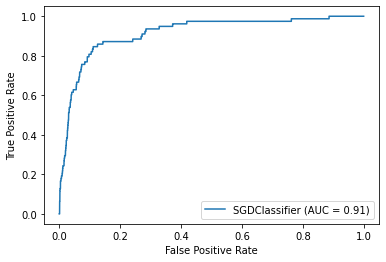

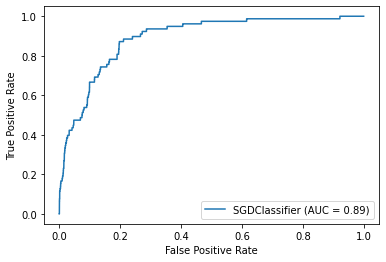

In [14]:
# it fits a linear support vector machine.
# first graph is with SMOTEd data (50-50 balanced data set), second is not.
from sklearn.linear_model import SGDClassifier
clf =  SGDClassifier(max_iter=10000, tol=1e-3, random_state=42)
runClassifier(X_trainSMOTE, y_trainSMOTE, X_test, y_test, clf)
clf =  SGDClassifier(max_iter=10000, tol=1e-3, random_state=42)
runClassifier(X_train, y_train, X_test, y_test, clf)

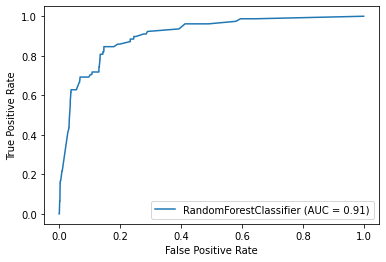

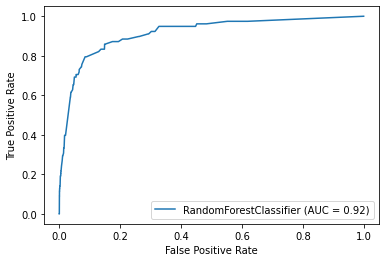

In [15]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=2, random_state=42) 
runClassifier(X_trainSMOTE, y_trainSMOTE, X_test, y_test, clf)
clf = RandomForestClassifier(max_depth=2, random_state=42) 
runClassifier(X_train, y_train, X_test, y_test, clf)

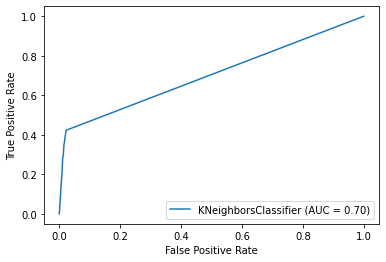

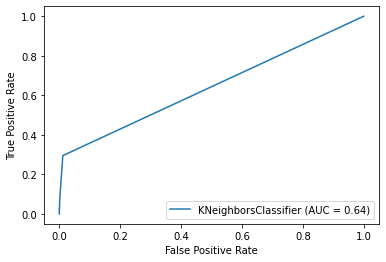

In [18]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=10) 
runClassifier(X_trainSMOTE, y_trainSMOTE, X_test, y_test, clf)
clf = KNeighborsClassifier(n_neighbors=10) 
runClassifier(X_train, y_train, X_test, y_test, clf)